# SCENTInEL
#### sc ElasticNet transductive and inductive ensemble learning

# Subgraph weighting modules

##### Ver:: A2_V6
##### Author(s) : Issac Goh
##### Date : 220823;YYMMDD
### Author notes
    
### Features to add

### Modes to run in


In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scentinel as scent
import pickle as pkl
import matplotlib.pyplot as plt


#¢ new modules
import psutil
import time
import threading
from scipy.interpolate import UnivariateSpline
from queue import Queue, Empty
import scipy

Make sure that Python modules winreg, win32api or win32con are installed.
INFO: blas_opt_info:
INFO: blas_armpl_info:
INFO: customize UnixCCompiler
INFO:   libraries armpl_lp64_mp not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: blas_mkl_info:
INFO:   libraries mkl_rt not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: blis_info:
INFO:   libraries blis not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: openblas_info:
INFO:   libraries openblas not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: accelerate_info:
INFO:   NOT AVAILABLE
I

In [2]:
models = {
'pan_fetal_wget':'https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/v2/Pan_Fetal_Human.pkl',
'YS_wget':'https://storage.googleapis.com/haniffalab/yolk-sac/YS_X_A2_V12_lvl3_ELASTICNET_YS.sav',
}

adatas_dict = {
'pan_fetal_wget':'https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad',
'YS_wget':'https://app.cellatlas.io/yolk-sac/dataset/23/download',
'YS_local':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_qc_raw_obsm.h5ad',
'YS_pre_agm':'https://app.cellatlas.io/yolk-sac/dataset/10/download',
'FLIV_wget':'https://app.cellatlas.io/fetal-liver/dataset/1/download',
'int_atlas_sub':'/nfs/team298/ar32/Thesis_lab_hdca/label_testing_on_vae/scENTInEL/example_notebooks/Simple_sampled_adata_V1.h5ad',
'int_atlas_full':'/nfs/team298/ar32/Thesis_lab_hdca/from_kemal/14_dataset_with_leiden.h5ad',
}

In [9]:
#setup global params:
# Variable assignment
train_model = False
adata_key = 'YS_local'#'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local 
data_merge = False # read and merge multiple adata (useful, but keep false for now)
model_key = 'new_example_model'#'pan_fetal_wget'#'test_low_dim_ipsc_ys'# key for model of choice can be either url or local 
#dyn_std = 1.96 # Dynamic cutoffs using std of the mean for each celltype probability, gives a column notifying user of uncertain labels 1 == 68Ci, 1.96 = 95CI
freq_redist = 'LVL3'#'cell.labels'#'False#'cell.labels'#False # False or key of column in anndata object which contains labels/clusters // not currently implemented
QC_normalise = False # should data be normalised?

# setup model parameters:
model_params = {
'feat_use': 'LVL3',
'train_x_partition' : 'X_scvi', # what partition was the data trained on?
'penalty':'elasticnet', # can be ["l1","l2","elasticnet"],
'var_length' : 7500,
'batch_key' : None,
'sparcity' : 0.5, #If using LR without optimisation, this controls the sparsity in model C penalty for degree of regularisation
'max_iter' : 1000, #Increase if experiencing max iter issues
'thread_num' : -1,
'l1_ratio' : 0.5, #If using elasticnet without optimisation, this controls the ratio between l1 and l2)
'partial_scale' : False, # should data be scaled in batches?
'tune_hyper_params' : True, # Current implementation is very expensive, intentionally made rigid for now
'batch_correction' : False,
'loss':'logloss',
'sketch_tune':False, # warning, do not use this if you are already sub-sampling
    
# Stratified Bayes sampler kwargs
'sample_data_knn':True,
'straify_sampling':False,
'knn_key' : 'neighbors',
'sampling_rate': 0.1,# Apply empirical bayes sampling weighted by knn?
'weight_penalty': 'laplacian_SGD_pagerank', # Or 'entropy_distance' or "connectivity_ratio" or "laplacian" or "laplacian_SGD_pagerank"
'iterations': 10,#How many iterations of sampling to use for empirical bayes sampler? Probabilities update for each iteration and favour rare-states, increasing iter, naturally increases rare-sampling events
'representation_priority': 0.7, # This exponentially controls the sampling rate for rare-states, where 1 represents low-prioritisation, 0.1 represetns maximum prioritisation
'replace': True, # Allows model to clone cells
'equal_allocation': False, # Forces model to create equal representation sets
'resample_clones':True,
'pl_label_entropy':False,
}

In [10]:
# load master graph
adata =  scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise, backed='r')

#create some sub-graphs
adata_sub_dict = {}
adata.obs['age'].unique()
subs = ['4PCW']
for sub in subs:
    adata_sub_dict[sub] = adata[adata.obs['age'].isin([sub])].to_memory()

## Integrating Subgraph Information into a Main Graph

### Introduction

In single-cell transcriptomics, deciphering cellular heterogeneity often involves analyzing local neighborhoods within cellular similarity graphs. Our objective is to combine insights from multiple subgraphs into a primary graph, focusing on leveraging the unique localized properties of each subgraph.

### Methodology

#### Local Density as a Measure of Significance:

Each node's local density in a subgraph serves as an indicator of its significance. Defined as:

$$
\text{density}(i) = \sum_{j} w_{ij}
$$

where \( w_{ij} \) is the weight of the edge connecting nodes \( i \) and \( j \), the local density captures the cumulative connection strengths of node \( i \). A higher density suggests the node's interactions are particularly pronounced in that subgraph, potentially hinting at unique cellular states or interactions.

#### Normalized Accumulative Integration:

The accumulator matrix, \( A \), initialized with zeros, has the same dimensions as the main matrix:

$$
A_{ij} = 0, \ \forall i,j
$$

The accumulator serves multiple purposes:

1. **Consolidation**: It aggregates edge values from all subgraphs.
2. **Normalization**: Divides the accumulated value by the number of subgraphs that contribute to each edge to obtain an average.
3. **Robustness**: Ensures that edges present in multiple subgraphs are treated uniformly, mitigating biases from the order of subgraph processing.

For each subgraph, the edge weights are multiplied by their starting node's local density, emphasizing edges in denser regions:

$$
A_{ij} \leftarrow \frac{A_{ij} + w_{ij} \times \text{density}(i)}{\text{counts}(i, j)}
$$

where $(\text{counts}(i, j)$ represents the number of times edge \(i, j\) is observed across subgraphs.

#### Integration into the Main Graph:

After accumulating values from all subgraphs:

1. **Direct Addition**: Edges present in subgraphs but absent in the main graph are directly added.
2. **Weighted Update**: For existing edges, the main graph's edge weight, $( M_{ij} )$, is updated using the average of its original weight and the corresponding accumulated value:

$$
M_{ij} \leftarrow \frac{M_{ij} + A_{ij}}{2}
$$

#### Post-processing:

Finally, to maintain the integrity of the main graph:

1. The matrix is made symmetric.
2. Any self-loops are removed.

### Conclusion:

Our normalized accumulative integration approach ensures that insights from all subgraphs are uniformly integrated into the main graph. By weighting edge updates with local densities and normalizing them based on counts, we emphasize connections that are particularly significant within their respective subgraphs. This leads to a more comprehensive and balanced representation of cellular interactions in the main graph.

In [11]:
import scipy.sparse as sp
def extract_connectivity_matrices(adata, adata_sub_dict, knn_key):
    """
    Extract the large matrix and the smaller matrices from the provided adata objects.
    """
    # Extract the main connectivity matrix from the main adata object
    main_matrix =  adata.obsp[adata.uns[model_params['knn_key']]['connectivities_key']]
    
    # Extract the smaller matrices from the subsetted adata objects
    sub_matrices = {sub:  sub_adata.obsp[sub_adata.uns[model_params['knn_key']]['connectivities_key']] for sub, sub_adata in adata_sub_dict.items()}
    
#     sub_adata.obsp[sub_adata.uns[model_params['knn_key']]['connectivities_key']]
#     adata.obsp[adata.uns[model_params['knn_key']]['connectivities_key']]
    return main_matrix, sub_matrices


def compute_density(matrix):
    """
    Compute the local density for each cell in the provided matrix.
    Density is defined as the sum of connectivity weights in a row.
    """
    return matrix.sum(axis=1).A1

def geometric_mean_weighted_update(main_matrix, sub_matrix, sub_density):
    """
    Update the main matrix using the geometric mean weighted by the local density from the sub_matrix.
    """
    rows, cols = sub_matrix.nonzero()
    for i, j in zip(rows, cols):
        # Compute the geometric mean weighted by the local density
        sub_weight = sub_matrix[i, j] * sub_density[i]
        main_weight = main_matrix[i, j] if i < main_matrix.shape[0] and j < main_matrix.shape[1] else 0
        update_weight = np.sqrt(main_weight * sub_weight)
        main_matrix[i, j] = update_weight

    return main_matrix


def get_node_mapping(main_barcodes, sub_barcodes):
    """
    Determine the mapping of nodes from the sub-matrix to the main matrix.
    """
    return {i: main_barcodes.index(sub_barcodes[i]) for i in range(len(sub_barcodes))}

def accumulate_subgraph_weights_normalized(main_matrix, adata_sub_dict, main_barcodes):
    """
    Accumulate the weighted edge values from all subgraphs into an accumulator matrix using normalized addition.
    """
    # Initialize the accumulator with zeros in CSR format and a count matrix
    accumulator = sp.lil_matrix(main_matrix.shape, dtype=np.float32)
    counts = sp.lil_matrix(main_matrix.shape, dtype=np.int32)
    
    for sub_key, sub_adata in adata_sub_dict.items():
        print('Processing subgraph {}'.format(sub_key))
        
        # Extract barcodes for the subgraph
        sub_barcodes = list(sub_adata.obs.index)
        
        # Determine the node mapping from subgraph to main graph
        mapping = get_node_mapping(main_barcodes, sub_barcodes)
        
        # Extract matrix from the sub_adata
        matrix = sub_adata.obsp[sub_adata.uns[model_params['knn_key']]['connectivities_key']]
        
        # Compute the density for the smaller matrix
        sub_density = compute_density(matrix)
        
        # Apply sigmoid scaling to the density information
        sub_density = 1 / (1 + np.exp(-sub_density))
        
        # Create a diagonal matrix with densities to multiply with the subgraph matrix
        density_diag = sp.diags(sub_density)
        
        # Compute the weighted matrix
        weighted_matrix = matrix.dot(density_diag)
        
        # Map the weighted matrix values to the accumulator using advanced indexing
        print("mapping the weighted matrix to the accumulator for subgraph {}".format(sub_key))
        i_sub, j_sub = weighted_matrix.nonzero()
        i_main = [mapping[i] for i in i_sub]
        j_main = [mapping[j] for j in j_sub]
        
        # Convert to CSR for efficient operations
        accumulator = accumulator.tocsr()
        counts = counts.tocsr()

        # Accumulate using addition and maintain counts without looping
        accumulator[i_main, j_main] += weighted_matrix[i_sub, j_sub].A1
        counts[i_main, j_main] += 1

        # Identify non-zero entries in counts
        nonzero_rows, nonzero_cols = counts.nonzero()

        # Normalize accumulator values by their counts without looping
        accumulator[nonzero_rows, nonzero_cols] = (accumulator[nonzero_rows, nonzero_cols].A * (1.0 / counts[nonzero_rows, nonzero_cols].A1))


    return accumulator.tocsr()

def integrate_matrices_normalized(adata, main_matrix, adata_sub_dict):
    """
    Integrate the information from all subgraphs into the main matrix.
    """
    # Extract barcodes for the main graph
    main_barcodes = list(adata.obs.index)
    
    # Accumulate the weighted edge values from all subgraphs
    accumulator = accumulate_subgraph_weights_normalized(main_matrix, adata_sub_dict, main_barcodes)

    # Identify overlapping non-zero entries between main_matrix and accumulator
    overlapping_nonzeros = main_matrix.multiply(accumulator)
    overlapping_rows, overlapping_cols = overlapping_nonzeros.nonzero()

    # Update weights for overlapping entries using advanced indexing
    overlapping_values_main = main_matrix[overlapping_rows, overlapping_cols].A1  # Convert matrix to 1D array
    overlapping_values_acc = accumulator[overlapping_rows, overlapping_cols].A1    # Convert matrix to 1D array

    updated_weights = (overlapping_values_main + overlapping_values_acc) / 2  # Take average

    # Update the main matrix with the updated weights
    main_matrix[overlapping_rows, overlapping_cols] = updated_weights

    # Add edges that are in accumulator but not in the main graph
    non_overlapping = accumulator - overlapping_nonzeros
    non_overlapping_rows, non_overlapping_cols = non_overlapping.nonzero()
    main_matrix[non_overlapping_rows, non_overlapping_cols] = non_overlapping[non_overlapping_rows, non_overlapping_cols].A1

    # Ensure the matrix is symmetric and remove any self-loops
    main_matrix = (main_matrix + main_matrix.T) / 2
    main_matrix.setdiag(0)
    
    return main_matrix


# Extract matrices from adata objects
main_matrix, sub_matrices = extract_connectivity_matrices(adata, adata_sub_dict, model_params['knn_key'])

# Integrate the matrices using the single-pass approach
integrated_matrix_single_pass = integrate_matrices_normalized(adata, main_matrix, adata_sub_dict)

Processing subgraph 4PCW
mapping the weighted matrix to the accumulator for subgraph 4PCW


In [ ]:
adata.obsp['connectivities'] = integrated_matrix_single_pass
sc.tl.umap(adata)
sc.pl.umap(adata,color = 'LVL3')

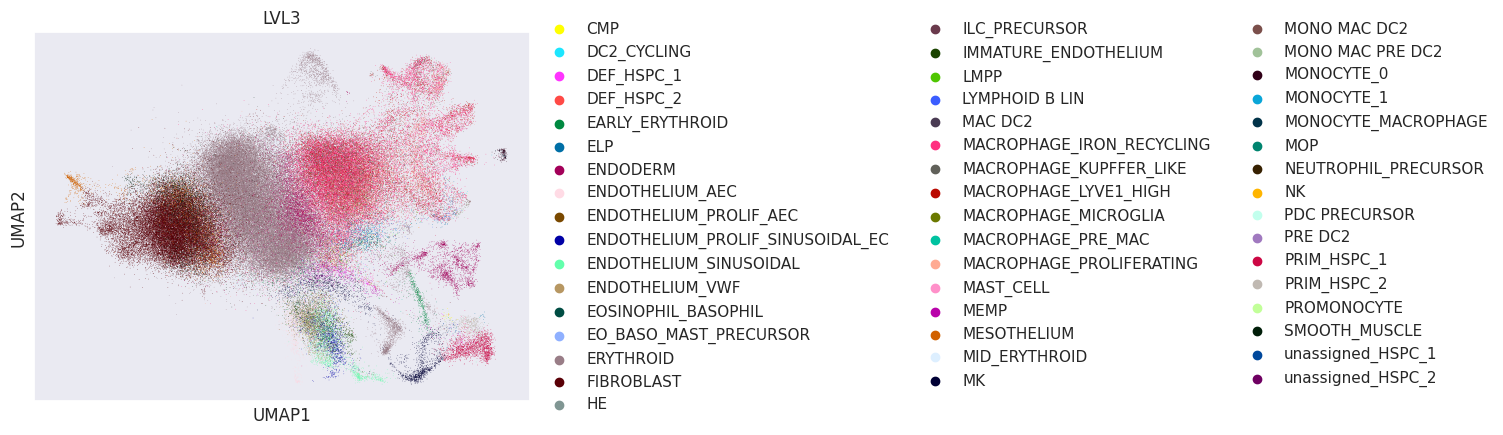

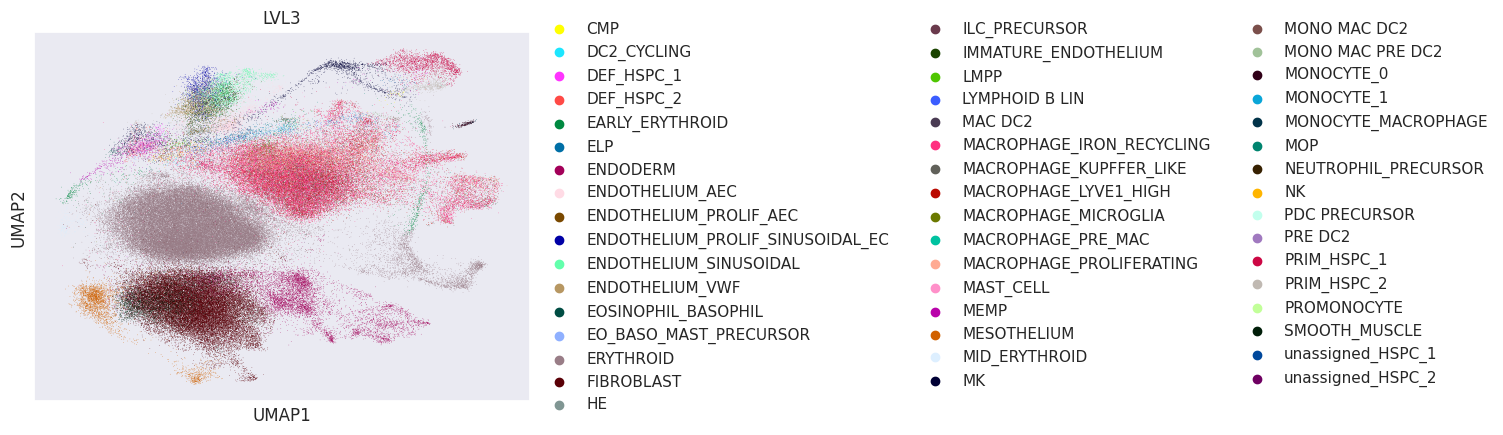

In [92]:
adata_orig = adata.to_memory()
adata.obsp['connectivities'] = integrated_matrix_single_pass
sc.tl.umap(adata)
sc.tl.umap(adata_orig)
sc.pl.umap(adata,color = 'LVL3')
sc.pl.umap(adata_orig,color = 'LVL3')